In [2]:
import numpy as np
import pandas as pd
import seaborn_image as isns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import math
import random

from skimage.io import imread
from skimage.io import imshow
from skimage.transform import resize




References:
https://neuraldatascience.io/8-mri/read_viz.html
https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


In [153]:
input_path = 'Alzheimer_s Dataset/train'
categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'] #our labels manually set
#or os.listdir(input_path)

images = []
labels = []

numberofimages = []

#similar to rmarkdown to get file directories
for category in categories:
    numberofimages.append(len(os.listdir(os.path.join(input_path,category))))
    for file in os.listdir(os.path.join(input_path, category)):
        image_paths = os.path.join(input_path,category, file) #image in this case refers to title of the image
        image = imread(image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all images
        images.append(image)
        labels.append(category)


In [4]:
#number of images
numberofimages

[2560, 1792, 717, 52]

In [108]:
#Splitting it to respective list
nonDemented = images[1:2561]
veryMildDemented = images[2561:4353]
MildDemented = images[4353:5070]
ModerateDemented = images[5069:5122]

lst = [nonDemented, veryMildDemented, MildDemented, ModerateDemented]

In [154]:
#dimensions of an image
print(nonDemented[1].shape)

(208, 176)


In [ ]:
plt.imshow(nonDemented[])

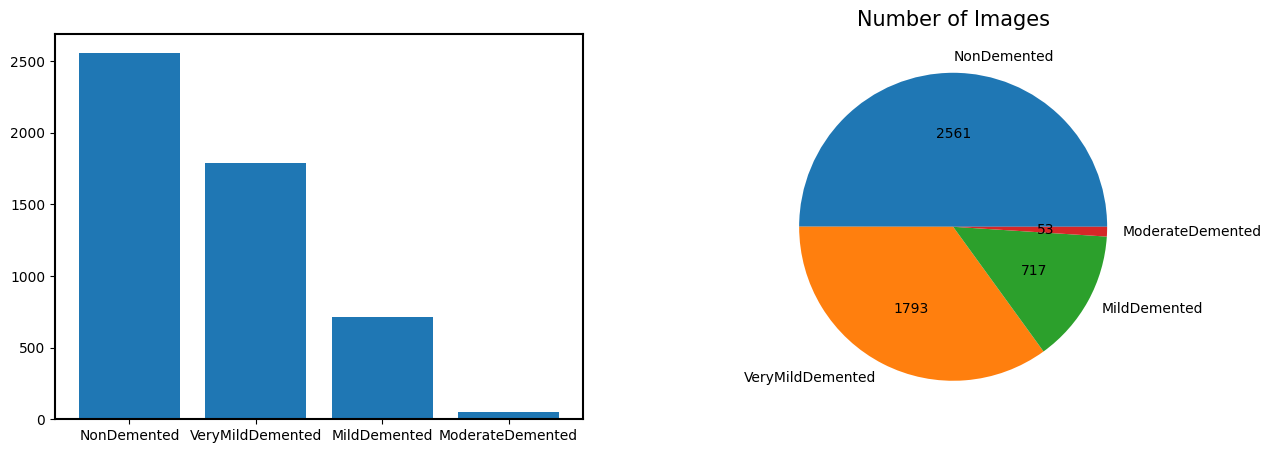

In [94]:
#Plotting number of images for visual representation
fig, ax = plt.subplots(1,2 , figsize = (15,5))
ax[0].bar(categories, numberofimages)
ax[1].pie(numberofimages, labels= categories, autopct = lambda x: math.ceil(x/100 * sum(numberofimages)))
ax[1].set_title('Number of Images')
plt.show()

#Shows some need for data augmentation since insufficient samples for ModerateDemented.
#We can do rotations or cropping into image for data augmentation.

#Things to analyze
Shape of dataset1 and dataset2 --- pixels
Most important section of data(like can we somehow extract)
identity the progression of alzheimer maybe how much the white part increases in its mean for each stage

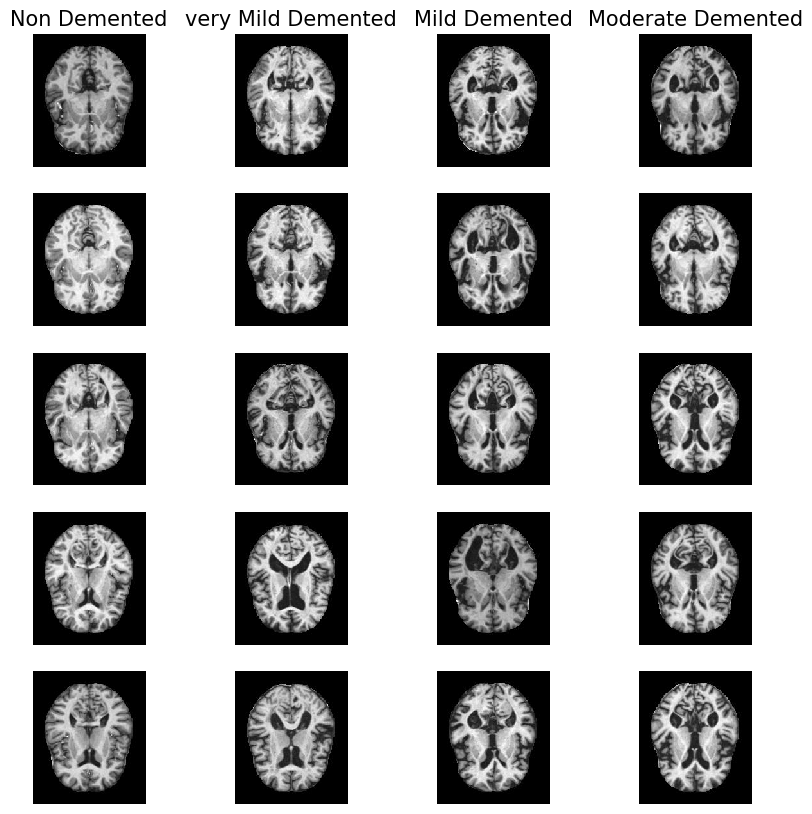

In [247]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like
fig,axes = plt.subplots(5,4, figsize = (10,10))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        axes[j,i].imshow(img, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 15)
axes[0,1].set_title('very Mild Demented', fontsize = 15)
axes[0,2].set_title('Mild Demented', fontsize = 15)
axes[0,3].set_title('Moderate Demented', fontsize = 15)
plt.show()

In [251]:
#Flatten 5 images and join them together then plot a histogram to get the rough distribution of the pixels rgb;
allFlattened = []
for i in range(len(lst)):
    flat = []
    for j in range(10):
        flat.extend(lst[i][j].flatten()) #extend function instead of append to add raw values rather than a list
    allFlattened.append(flat)


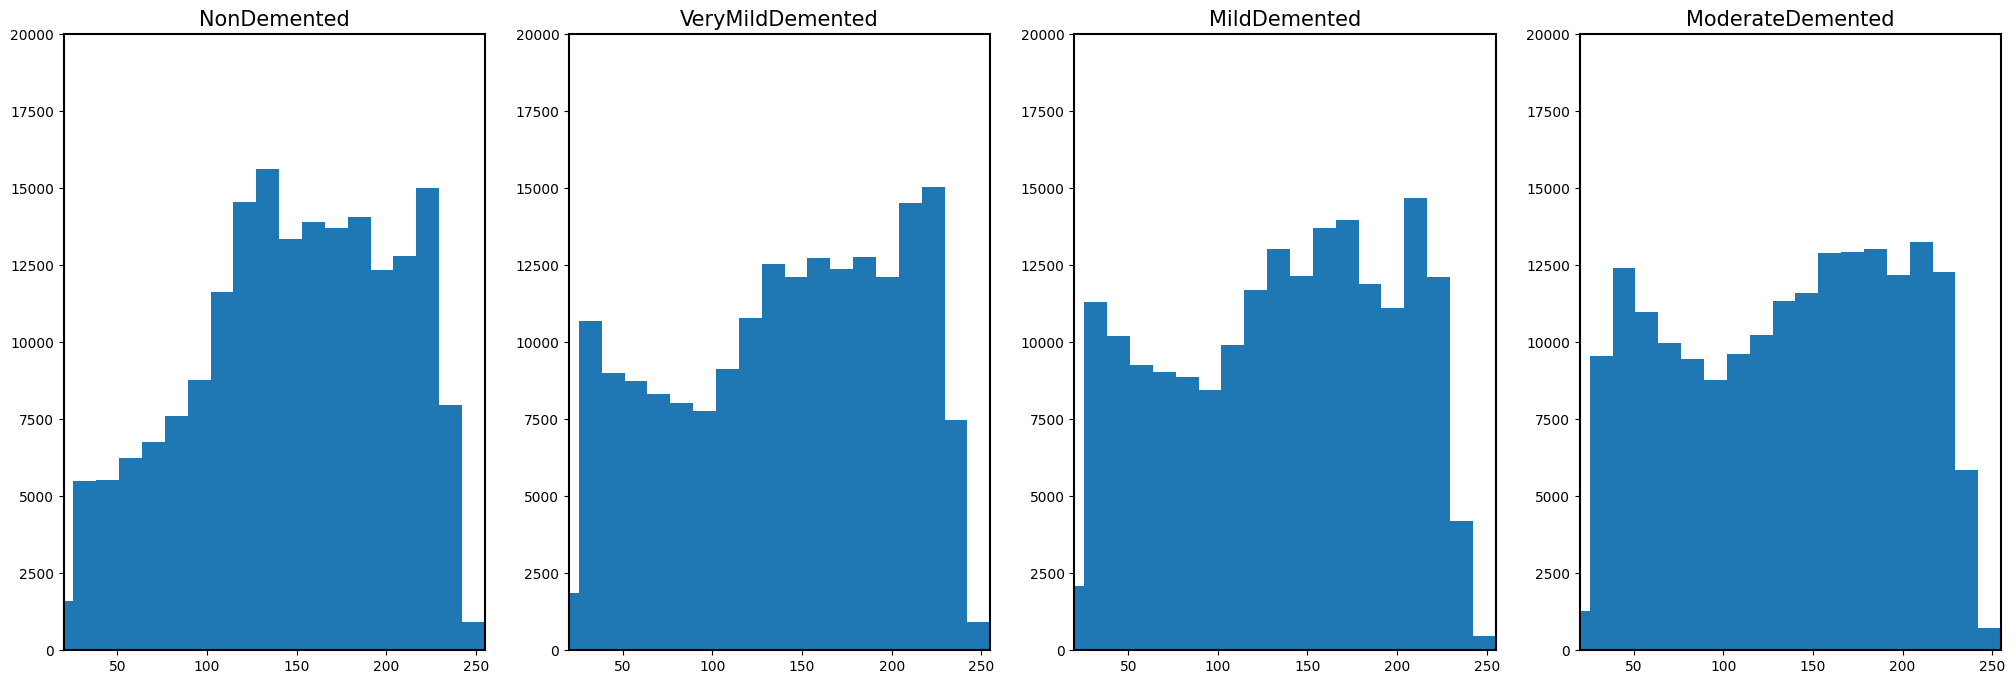

In [266]:
fig, axes = plt.subplots(1,4, figsize = (25,8))
for i in range(len(allFlattened)):
    axes[i].hist(allFlattened[i], bins = 20)
    axes[i].set_title(categories[i])
    axes[i].set_xlim([20,255])
    axes[i].set_ylim([0,20000])


Seems to indicate that there are more black-gray pixels as severity increases using the first 10 data as references
Can play around with the bin number but it shows almost the same r/s

Now convert it to binary image by setting pixel 50 to approximately 100 as the region as white and the rest as black and do an image visualization

In [308]:
tst = nonDemented[1]

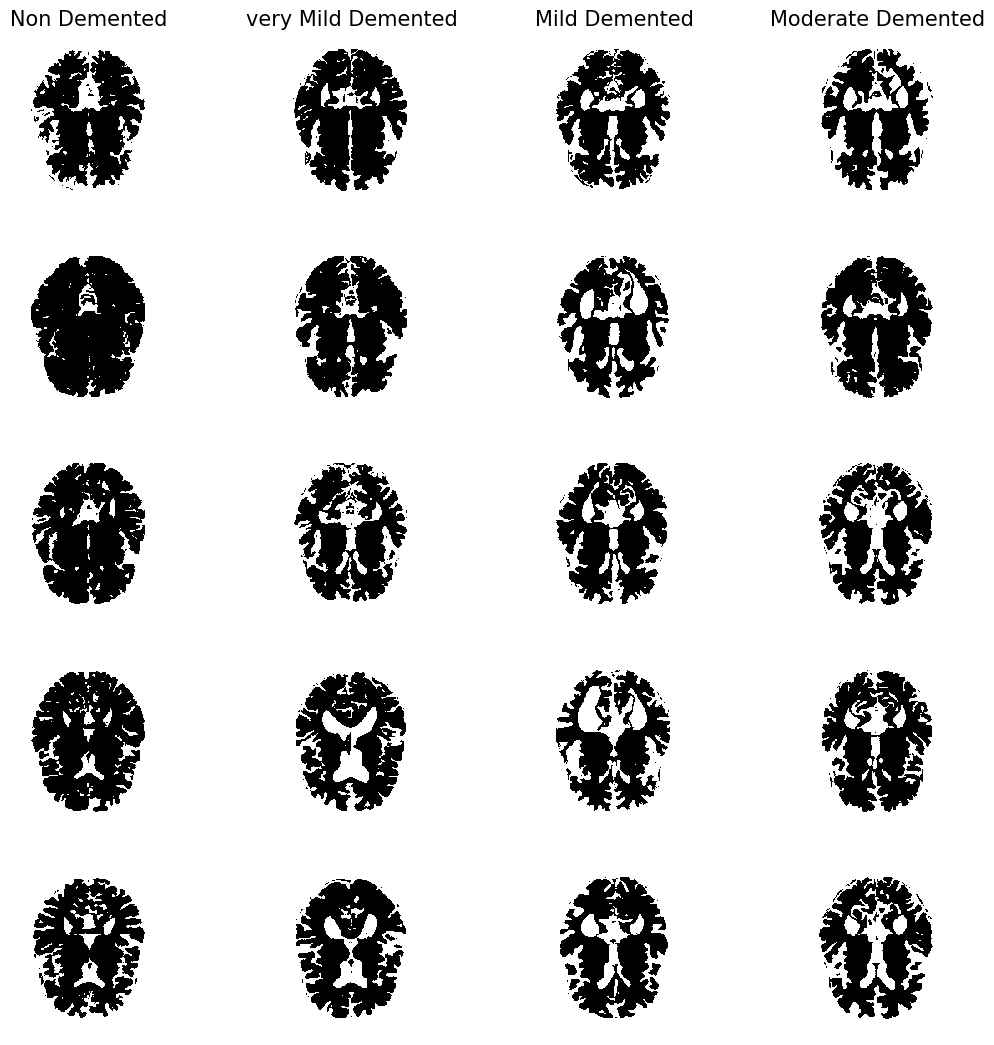

In [328]:
#Convert all pictures to binary to showcase degree of white are
fig,axes = plt.subplots(5,4, figsize = (13,13))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        #binary1 = np.where(img >= 50,1,0)
        binary2 = np.where(img <= 100,1,0)
        #newimg = binary1 + binary2
        axes[j,i].imshow(binary2, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 15)
axes[0,1].set_title('very Mild Demented', fontsize = 15)
axes[0,2].set_title('Mild Demented', fontsize = 15)
axes[0,3].set_title('Moderate Demented', fontsize = 15)
plt.show()

Appears that the middle region has increasing number of white pixels as well as the sides of the bottom

this coincides with the picture below

#reference to image
https://www.mdpi.com/1422-0067/22/4/2110


In [11]:

s = plt.imread('reference images')
plt.imshow(s)

#refimg = plt.imread(refpath)

PermissionError: [Errno 13] Permission denied: 'reference images'

<AxesSubplot:>

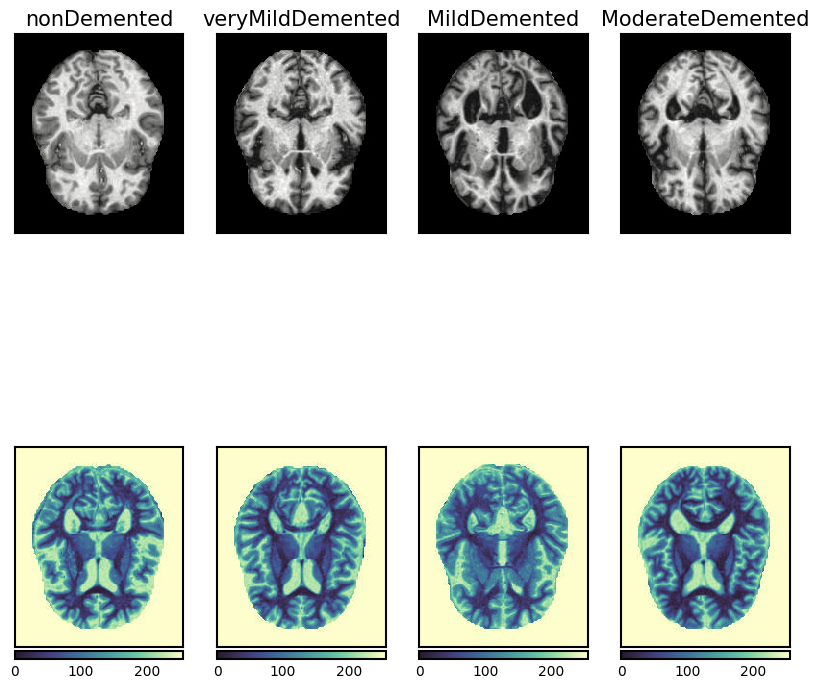

In [55]:
fig, axes = plt.subplots(2,4, figsize = (10,10))
isns.imgplot(nonDemented[1], gray= True, ax= axes[0,0], orientation= 'h', cbar=False)
axes[0,0].set_title('nonDemented')
isns.imgplot(veryMildDemented[1], gray= True, ax = axes[0,1],orientation= 'h', cbar = False)
axes[0,1].set_title('veryMildDemented')
isns.imgplot(MildDemented[1], gray = True, ax = axes[0,2],orientation= 'h', cbar = False)
axes[0,2].set_title('MildDemented')
isns.imgplot(ModerateDemented[1], gray = True, ax = axes[0,3],orientation= 'h', cbar = False)
axes[0,3].set_title('ModerateDemented')

#make it into rgb so can visualize better
isns.imgplot(np.invert(nonDemented[20]), gray= True, ax= axes[1,0], orientation= 'h', cmap = 'deep')
isns.imgplot(np.invert(veryMildDemented[20]), gray= True, ax = axes[1,1],orientation= 'h', cmap='deep')
isns.imgplot(np.invert(MildDemented[20]), gray = True, ax = axes[1,2],orientation= 'h', cmap = 'deep')
isns.imgplot(np.invert(ModerateDemented[20]), gray = True, ax = axes[1,3],orientation= 'h', cmap = 'deep')



In [55]:
from skimage.color import rgb2hsv
from skimage.segmentation import chan_vese
import skimage as ski
from skimage import exposure

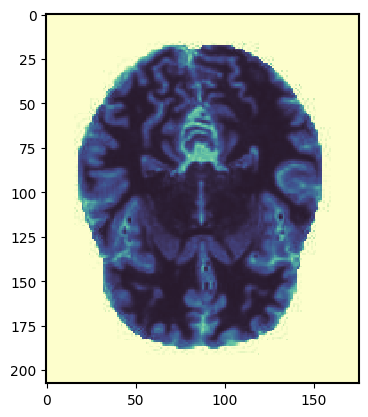

In [80]:
im1 = exposure.adjust_gamma(np.invert(nonDemented[1]),2)
plt.imshow(im1,)



In [101]:
im1 = exposure.adjust_gamma(np.invert(ModerateDemented[1]), 2)
im2 = exposure.adjust_gamma(np.invert(MildDemented[20]),-2)
#plt.imshow(im1, cmap = 'jet')
plt.imshow(im2, cmap = 'jet')

ValueError: Gamma should be a non-negative real number.

<AxesSubplot:>

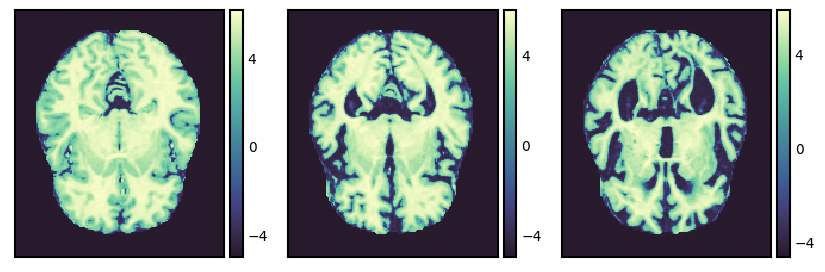

In [50]:

im1 = nonDemented[1]
im2 = ModerateDemented[1]
im3 = MildDemented[1]
cv = chan_vese(im1, mu=0.001, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)
cv2 = chan_vese(im2, mu=0.001, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)
cv3 = chan_vese(im3, mu=0.001, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)
fig, axes = plt.subplots(1,3, figsize = (10,10))
isns.imshow(cv[1], ax = axes[0])
isns.imshow(cv2[1], ax = axes[1])
isns.imshow(cv3[1], ax = axes[2])